In [1]:
%matplotlib inline
import h2o
import xgboost
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pylab as plt
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from h2o.estimators.random_forest import H2ORandomForestEstimator
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Function

In [2]:
def str_to_num(df, train=True, activity_id = True):
    '''
    ppl_id : del string and change dtype to num
    activity id : del number and str(act)
    type : del string and change dtype to num
    bool : 0, 1
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    train : bool
        train :True, test : False
    --------
    '''
    col_list = list(df)
    col_list.remove('date_x')
    col_list.remove('date_y')
    if train:
        col_list.remove('outcome')
        
    for col in col_list[:col_list.index('char_9_y')+1]:
        if col == 'activity_id':
            if activity_id == True:
                df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('_')[0])
                df.replace('act', '', regex=True, inplace = True)
        elif col == 'people_id':
            df.loc[:,col] = df.loc[:,col].apply(lambda x: x.split('_')[1])
        else :
            df.loc[:,col][df.loc[:,col].isnull()==False] = df.loc[:,col][df.loc[:,col].isnull()==False].apply(lambda x: x.split(' ')[1])
        df.loc[:, col] = pd.to_numeric(df.loc[:, col][df.loc[:,col].isnull()==False]).astype(int)
            
    for col in col_list[col_list.index('char_10_y'):col_list.index('char_38')+1]:
        df.loc[:,col] = df.loc[:,col].replace({True:1, False:0})
        
    return df

In [3]:
def date_modify(df):
    '''
    add week_x, week_y, and Past_days
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    df.insert(loc=list(df).index('date_x')+1 ,column='week_x', value=df['date_x'].dt.weekday)
    df.insert(loc=list(df).index('date_y')+1 ,column='week_y', value=df['date_y'].dt.weekday)
    df.insert(loc=list(df).index('week_x')+1 ,column='Past_days', value=(df.date_x - df.date_y).astype('timedelta64[D]'))
    df['days']=(pd.to_numeric(df.date_x)//86400000000000) - (pd.to_numeric(df.date_x)//86400000000000).min()
    return df

In [4]:
def add_bool_sum(df):
    '''
    add colum 'bool_sum' : sum of char_10_y ~ char_37
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    temp = df.copy()
    temp['bool_sum'] = temp.iloc[:,list(temp).index('char_10_y'):list(temp).index('char_37')].sum(axis=1)
    return temp

In [5]:
def num_to_cat(df, columns):
    '''
    change dtype(num to str)
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    columns : list
    --------
    '''
    temp = df.copy()
    temp.loc[:,columns] = pd.DataFrame(temp.loc[:,columns], dtype='str')
    return temp

In [134]:
def one_hot_encoder(df, columns):
    '''
    columns encoding(one-hot-encoding)
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    columns : list
    --------
    '''
    temp = df.copy()
    for col in columns:
        for i in list(pd.get_dummies(temp[col]))[-1::-1]:    
            temp.insert(loc=list(temp).index(col)+1 ,column=col+str(i), value=pd.get_dummies(temp.loc[:,col]).loc[:,i])
        temp = temp.drop([col], axis=1)
    return temp

In [ ]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

# 강사님 함수
def draw_decision_tree(model, feature_names):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

# data load & 전처리

### train data

In [6]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [7]:
str_to_num(df_merge, train=True)
date_modify(df_merge)
df_merge = add_bool_sum(df_merge)
del df_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### test data

In [8]:
df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')

In [9]:
# submissin 만들때 필요함
df_test_act_id = df_merge_test.activity_id.copy()

In [10]:
str_to_num(df_merge_test, train=False)
date_modify(df_merge_test)
df_merge_test = add_bool_sum(df_merge_test)
del df_test, df_people

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### save data

In [ ]:
# df_merge.to_csv("train_merge.csv")
# df_merge_test.to_csv("test_merge.csv")

In [ ]:
# df_merge = pd.read_csv('./train_merge.csv', parse_dates=['date_x', 'date_y'])
# df_merge_test = pd.read_csv('./test_merge.csv', parse_dates=['date_x', 'date_y'])

# group & date

In [11]:
df_gd = df_merge.loc[:, ['group_1', 'days', 'outcome']].copy()

In [12]:
df_gd_test = pd.DataFrame({'activity_id' : df_test_act_id, 'group_1' : df_merge_test.group_1, 'days' : df_merge_test['days'], 'outcome':np.nan})         

In [99]:
df_gd_test

,activity_id,days,group_1,outcome
0,act1_249281,3,22593,0.0
1,act2_230855,3,22593,0.0
2,act1_240724,89,25417,1.0
3,act1_83552,133,25417,1.0
4,act2_1043301,90,25417,1.0
5,act2_112890,133,25417,1.0
6,act2_1169930,90,25417,1.0
7,act2_1924448,90,25417,1.0
8,act2_1953554,90,25417,1.0
9,act2_1971739,134,25417,1.0


In [13]:
%%time
gp_0 = []
gp_1 = []
gp_01= []
for gp in df_gd.group_1.unique():
    if len(df_gd[df_gd.group_1==gp].loc[:,'outcome'].unique()) == 1:
        if df_gd[df_gd.group_1==gp].loc[:,'outcome'].iloc[0]:
            gp_1.append(gp)
        else:
            gp_0.append(gp)
    else :
        gp_01.append(gp)

Wall time: 4min 8s


In [14]:
%%time
gp_0_test = []
gp_1_test = []
gp_01_test= []
gp_nan_test = []
for col in df_gd_test.group_1.unique():
    if col in gp_0:
        gp_0_test.append(col)
    elif col in gp_1:
        gp_1_test.append(col)
    elif col in gp_01:
        gp_01_test.append(col)
    else :
        gp_nan_test.append(col)

Wall time: 5.67 s


In [36]:
%%time
gp_dict = dict()
for gp in gp_01_test:
    gp_dict[gp] = []
    a = df_gd[df_gd.group_1==gp].loc[:,['days','outcome']].sort_values(by=['days'])
    for i in range(len(df_gd[df_gd.group_1==gp])-1):
        if a.iloc[i].outcome - a.iloc[i+1].outcome == 1:
            gp_dict[gp].append(a.iloc[i].days)
            gp_dict[gp].append(a.iloc[i+1].days)
        elif a.iloc[i].outcome - a.iloc[i+1].outcome == -1:
            gp_dict[gp].append(-a.iloc[i].days)
            gp_dict[gp].append(a.iloc[i+1].days)
        else:
            pass

Wall time: 1min 40s


In [37]:
gp_dict

{7111: [-80, 83],
 2223: [74, 178],
 17688: [282, 283, -293, 297],
 10082: [311, 368],
 17883: [-116, 143],
 23761: [395, 408],
 19334: [-122, 200],
 14940: [296, 347],
 25318: [154, 158],
 12560: [65, 66, -99, 107],
 20108: [-118, 121],
 16762: [-178, 179],
 1171: [-217, 252],
 1227: [348, 375],
 5748: [228, 321],
 18981: [-5, 32],
 21014: [-13, 45],
 5031: [170, 180, -180, 229],
 20343: [103, 199, -235, 247],
 4610: [173, 180, -254, 258],
 1298: [212, 226],
 5188: [375, 383],
 2905: [356, 359],
 4442: [285, 291],
 17548: [6, 18],
 19746: [363, 383],
 1482: [360, 361, -364, 367],
 26244: [88, 115, -334, 363],
 39769: [354, 380],
 23578: [-179, 192],
 18261: [363, 367],
 33121: [40, 47, -47, 59],
 1039: [352, 363],
 22937: [172, 184, -268, 271],
 30461: [-166, 177],
 19152: [268, 269],
 764: [172, 284],
 12001: [119, 228],
 9702: [-191, 192],
 27730: [334, 363],
 19752: [-252, 253],
 31294: [-277, 310],
 8954: [341, 342],
 8771: [200, 209, -213, 230],
 17387: [12, 13],
 9442: [225, 227

In [16]:
len(gp_0), len(gp_1), len(gp_01)

(12597, 13049, 4253)

In [17]:
len(gp_0_test), len(gp_1_test), len(gp_01_test), len(gp_nan_test)

(1630, 4285, 1400, 4325)

In [18]:
len(df_gd_test[df_gd_test.loc[:,'outcome'].isnull()])

498687

In [19]:
df_gd_test.loc.__setitem__((df_gd_test.loc[:,'group_1'].isin(gp_0_test), ('outcome')), 0)

In [20]:
len(df_gd_test[df_gd_test.loc[:,'outcome'].isnull()])

302582

In [21]:
df_gd_test.loc.__setitem__((df_gd_test.loc[:,'group_1'].isin(gp_1_test), ('outcome')), 1)

In [22]:
len(df_gd_test[df_gd_test.loc[:,'outcome'].isnull()])

123302

In [23]:
%%time
idx_list = df_gd_test[df_gd_test.loc[:,'group_1'].isin(gp_01_test)].loc[:,'group_1'].index
df_gp01_test = df_gd_test[df_gd_test.loc[:,'group_1'].isin(gp_01_test)]

for idx in idx_list:
    if len(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]])==4:
        if gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0] < 0 :
            if (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0]) > df_gp01_test.loc[:,'days'].loc[idx]) or \
                abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0]) < df_gp01_test.loc[:,'days'].loc[idx]:
                df_gd_test.loc.__setitem__((idx, ('outcome')), 0)
            elif (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0]) < \
                  df_gp01_test.loc[:,'days'].loc[idx] < \
                  abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1])):
                df_gd_test.loc.__setitem__((idx, ('outcome')), 
                                           (df_gp01_test.loc[:,'days'].loc[idx] - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0])) \
                                           / (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1]) - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0])))
            elif (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][2]) < \
                  df_gp01_test.loc[:,'days'].loc[idx] < \
                  abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][3])):
                abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1])):
                df_gd_test.loc.__setitem__((idx, ('outcome')), 
                                           (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][3]) - df_gp01_test.loc[:,'days'].loc[idx]) \
                                           / (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][3]) - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][2])))
            else : 
                df_gd_test.loc.__setitem__((idx, ('outcome')), 1)
        else :
            if (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0]) > df_gp01_test.loc[:,'days'].loc[idx]) or \
                abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0]) < df_gp01_test.loc[:,'days'].loc[idx]:
                df_gd_test.loc.__setitem__((idx, ('outcome')), 1)
            elif (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0]) < \
                  df_gp01_test.loc[:,'days'].loc[idx] < \
                  abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1])):
                df_gd_test.loc.__setitem__((idx, ('outcome')), 
                                           (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1]) - df_gp01_test.loc[:,'days'].loc[idx]) \
                                           / (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1]) - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0])))
            elif (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][2]) < \
                  df_gp01_test.loc[:,'days'].loc[idx] < \
                  abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][3])):
                abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1])):
                df_gd_test.loc.__setitem__((idx, ('outcome')), 
                                           (df_gp01_test.loc[:,'days'].loc[idx] - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][2])) \
                                           / (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][3]) - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][2])))
            else : 
                df_gd_test.loc.__setitem__((idx, ('outcome')), 0)
    else :
        if gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0] < 0 :
            if abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0]) > df_gp01_test.loc[:,'days'].loc[idx]:
                df_gd_test.loc.__setitem__((idx, ('outcome')), 0)
            elif abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1]) < df_gp01_test.loc[:,'days'].loc[idx]: 
                df_gd_test.loc.__setitem__((idx, ('outcome')), 1)
            else :
                df_gd_test.loc.__setitem__((idx, ('outcome')), \
                                           (df_gp01_test.loc[:,'days'].loc[idx] - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1])) \
                                           / (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1]) - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0])))
        else :
            if abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0]) > df_gp01_test.loc[:,'days'].loc[idx]:
                df_gd_test.loc.__setitem__((idx, ('outcome')), 1)
            elif abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1]) < df_gp01_test.loc[:,'days'].loc[idx]: 
                df_gd_test.loc.__setitem__((idx, ('outcome')), 0)
            else:
                df_gd_test.loc.__setitem__((idx, ('outcome')), \
                                           (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1]) - df_gp01_test.loc[:,'days'].loc[idx]) \
                                           / (abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][1]) - abs(gp_dict[df_gp01_test.loc[:,'group_1'].loc[idx]][0])))      

                

Wall time: 6min


In [24]:
len(df_gd_test[df_gd_test.loc[:,'outcome'].isnull()])

69073

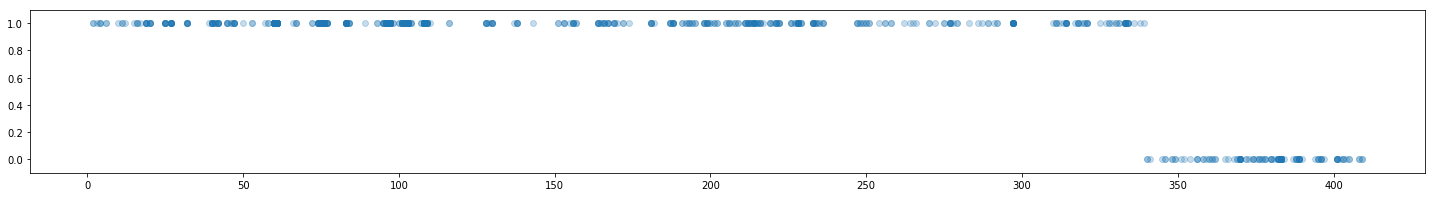

In [25]:
plt.figure(figsize=(25,3))
plt.scatter(df_gd[df_gd.loc[:,'group_1']==gp_01[0]]['days'], df_gd[df_gd.loc[:,'group_1']==gp_01[0]].outcome, alpha = 0.25) 
plt.ylim(-0.1,1.1)
plt.show()

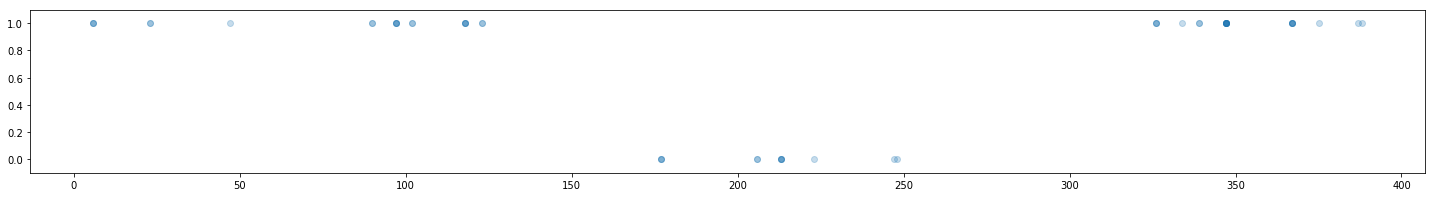

In [97]:
plt.figure(figsize=(25,3))
plt.scatter(df_gd[df_gd.loc[:,'group_1']==gp_01[1]]['days'], df_gd[df_gd.loc[:,'group_1']==gp_01[1]].outcome, alpha = 0.25) 
plt.ylim(-0.1,1.1)
plt.show()

# EDA

In [ ]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_merge[d].min().date()))
    print('  End of ' + d + ': ' + str(df_merge[d].max().date()))
    print('Range of ' + d + ': ' + str(df_merge[d].max() - df_merge[d].min()) + '\n')

In [ ]:
df_merge.describe()

In [ ]:
df_merge[['date_x', 'date_y']].describe()

In [ ]:
pd.DataFrame(df_merge.people_id, dtype='object').describe()

In [ ]:
df_merge.people_id.unique()

In [ ]:
# ppl 별 구매 경향
plt.figure(figsize=(20,30))
for i, ppl in enumerate(df_merge.people_id.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
df_merge.people_id.value_counts().head()

In [ ]:
# ppl 별 구매 경향 top 5
plt.figure(figsize=(20,10))
for i, ppl in enumerate([294918, 370270, 105739, 54699, 64887]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
# group 별 구매 경향
plt.figure(figsize=(20,30))
for i, group in enumerate(df_merge.group_1.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
# group 별 구매 경향 top 5

plt.figure(figsize=(20,10))
for i, group in enumerate([17304, 667, 8386, 9280,450]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
sns.factorplot(x="week_x", y="outcome", row="activity_category", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

In [ ]:
sns.factorplot(x="activity_category", y="outcome", row="week_x", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

#### sample

In [ ]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()
df_sample = add_bool_sum(df_sample)

In [ ]:
df_sample2 = df_merge.sample(frac = 0.1, random_state=1).copy()
df_sample2 = add_bool_sum(df_sample2)

In [ ]:
df_sample.groupby(['activity_id', 'activity_category']).count()

In [ ]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['Past_days'])
sns.kdeplot(df_sample[df_sample.outcome==1]['Past_days'])
plt.show()

In [ ]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['week_x'])
sns.kdeplot(df_sample[df_sample.outcome==1]['week_x'])
plt.show()

#### char_1_x ~ char_9_x

In [ ]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_1_x'):list(df_sample).index('char_9_x')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_2_y ~ char_9_y

In [ ]:
sns.countplot('char_2_y', hue='outcome', data=df_sample)
plt.show

In [ ]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_3_y'):list(df_sample).index('char_9_y')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_10_y ~ char_37

In [ ]:
plt.figure(figsize=(20,30))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_10_y'):list(df_sample).index('char_37')+1]):
    plt.subplot(7,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot('bool_sum', hue='outcome', data=df_sample)
plt.show()

#### char_38

In [ ]:
facet = sns.FacetGrid(df_sample, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_sample['char_38'].max()))
facet.add_legend()

plt.show()

In [ ]:
sns.boxplot(x="outcome", y="char_38", data=df_sample)
plt.show()

In [ ]:
del df_sample, df_sample2

# feature selection

In [ ]:
model1 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + \
                            char_29 + char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37", data=df_merge)
model2 = sm.OLS.from_formula("outcome ~ bool_sum", data=df_merge)
model3 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + char_29 + \
                            char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37 + bool_sum", data=df_merge)
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()

sm.stats.anova_lm(result1, result2, result3)

In [ ]:
sm.stats.anova_lm(result1)

In [ ]:
sm.stats.anova_lm(result2)

In [ ]:
sm.stats.anova_lm(result3)

# modeling

#### fillna(0)

In [110]:
df_merge.fillna(0, inplace=True)
df_merge_test.fillna(0, inplace=True)

#### columns

In [111]:
a = list(df_merge)
a.remove('date_x')
a.remove('date_y')
a.remove('bool_sum')
a.remove('people_id')
a.remove('activity_id')
a.remove('week_x')
a.remove('week_y')
a.remove('days')
a.remove('group_1')
a.remove('outcome')
print(a)

['Past_days', 'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']


In [ ]:
df_merge2 = one_hot_encoder(df_merge, ['activity_id', 'activity_category'])

In [ ]:
df_merge_test2 = one_hot_encoder(df_merge_test, ['activity_id', 'activity_category'])

In [ ]:
a2 = list(df_merge2)
a2.remove('date_x')
a2.remove('date_y')
a2.remove('bool_sum')
a2.remove('people_id')
a2.remove('week_x')
a2.remove('week_y')
a2.remove('days')
a2.remove('group_1')
a2.remove('outcome')
print(a2)

## 로지스틱 회귀분석

In [ ]:
logit_mod = sm.Logit.from_formula("outcome ~ Past_days + char_38 + bool_sum", data=df_merge)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

## 나이브 베이즈

+ 가우시안 정규 분포 나이브 베이즈 모형

In [ ]:
%%time
clf_norm = GaussianNB().fit(df_merge[a], df_merge.outcome)

In [ ]:
%%time
cross_val_score(clf_norm, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

## 의사 결정 나무

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(tree, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(tree, a)

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : tree2.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_tree.csv")

## 랜덤 포레스트

+ RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=10).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(rfc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
importance = rfc.feature_importances_
importance = pd.DataFrame(importance, index=df_merge.loc[:,a].columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]

plt.bar(x, y)

plt.show()

In [ ]:
importance.sort_values(by='Importance', ascending=False)

In [ ]:
# # rfc = RandomForestClassifier(n_estimators=30).fit(df_merge[a], df_merge.outcome) 0.88
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc.csv")

+ ExtraTreesClassifier

In [ ]:
%%time
efc = ExtraTreesClassifier(n_estimators=30, max_depth=10).fit(df_merge[a], df_merge.outcome)

In [ ]:
%%time
cross_val_score(efc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc.csv")

# xgboost

In [ ]:
%%time
xgb = xgboost.XGBClassifier(n_estimators=30, max_depth=10).fit(df_merge2[a2], df_merge2.outcome)

In [ ]:
%%time
cross_val_score(xgb, df_merge[a2], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb.predict(df_merge_test2[a2])}).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb2.csv")

# 퍼셉트론

# 서포트 벡터 머신

# voting

In [ ]:
df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 
                              'outcome0' : clf_norm.predict(df_merge_test[a]),
                              'outcome1' : tree.predict(df_merge_test[a]),
                              'outcome2' : rfc.predict(df_merge_test[a]),
                              'outcome3' : efc.predict(df_merge_test[a]),
                              'outcome4' : xgb.predict(df_merge_test2[a2]),
                             })
# df_submission.to_csv("df_submission_xgb2.csv")

In [ ]:
df_submission['outcome5'] = df_submission.outcome0 + df_submission.outcome1 + df_submission.outcome2 + df_submission.outcome3 + df_submission.outcome4             

In [ ]:
df_submission['outcome'] = df_submission['outcome5']//3

In [ ]:
df_submission = df_submission.loc[:,['activity_id', 'outcome']].copy()

In [ ]:
df_submission.set_index('activity_id',inplace=True)

In [ ]:
# df_submission.to_csv("df_submission_vote.csv")

# H2O

In [26]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.151-b12, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kwon\AppData\Local\Temp\tmpxkq4phjf
  JVM stdout: C:\Users\kwon\AppData\Local\Temp\tmpxkq4phjf\h2o_kwon_started_from_python.out
  JVM stderr: C:\Users\kwon\AppData\Local\Temp\tmpxkq4phjf\h2o_kwon_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,29 days
H2O cluster name:,H2O_from_python_kwon_prs46x
H2O cluster total nodes:,1
H2O cluster free memory:,891 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [27]:
coltype_dict = dict()
ignore_list = ['people_id', 'activity_id', 'group_1', 'char_10_x']
numeric_list = ['char_38', 'bool_sum', 'days', 'Past_days']
date_list = ['date_x', 'date_y']
for col in list(df_merge):
    type_ = 'string'
    if col in ignore_list:
        type_ = 'string'
    elif col in numeric_list:
        type_ = 'numeric'
    elif col in date_list:
        type_ = 'time'
    else:
        type_ = 'enum'
    coltype_dict[col] = type_
print(coltype_dict)
print()

na_dict = dict()
na_list = ['char_{}_x'.format(x) for x in range(1, 10)]
for item in na_list:
    na_dict[item] = ['0']
print(na_dict)

{'people_id': 'string', 'activity_id': 'string', 'date_x': 'time', 'week_x': 'enum', 'Past_days': 'numeric', 'activity_category': 'enum', 'char_1_x': 'enum', 'char_2_x': 'enum', 'char_3_x': 'enum', 'char_4_x': 'enum', 'char_5_x': 'enum', 'char_6_x': 'enum', 'char_7_x': 'enum', 'char_8_x': 'enum', 'char_9_x': 'enum', 'char_10_x': 'string', 'outcome': 'enum', 'char_1_y': 'enum', 'group_1': 'string', 'char_2_y': 'enum', 'date_y': 'time', 'week_y': 'enum', 'char_3_y': 'enum', 'char_4_y': 'enum', 'char_5_y': 'enum', 'char_6_y': 'enum', 'char_7_y': 'enum', 'char_8_y': 'enum', 'char_9_y': 'enum', 'char_10_y': 'enum', 'char_11': 'enum', 'char_12': 'enum', 'char_13': 'enum', 'char_14': 'enum', 'char_15': 'enum', 'char_16': 'enum', 'char_17': 'enum', 'char_18': 'enum', 'char_19': 'enum', 'char_20': 'enum', 'char_21': 'enum', 'char_22': 'enum', 'char_23': 'enum', 'char_24': 'enum', 'char_25': 'enum', 'char_26': 'enum', 'char_27': 'enum', 'char_28': 'enum', 'char_29': 'enum', 'char_30': 'enum', 'c

In [28]:
%%time
hf_merge1 = h2o.H2OFrame(df_merge , column_types=coltype_dict, na_strings=na_dict)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Wall time: 2min 45s


In [29]:
# del ignore_list, numeric_list, date_list

In [30]:
%%time
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=100,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

Wall time: 2 ms


In [31]:
%%time
rf_v1.train(a, 'outcome', training_frame=hf_merge1)

H2OTypeError: Argument `x` should be a None | integer | string | list(string | integer) | set(integer | string), got DataFrame          days  outcome
712174     19        1
1612744   401        0
1612745   401        0
1612746   401        0
1612750   402        0
1612748   404        0
1612749   404        0
1612747   405        0
1612751   405        0

In [32]:
%%time
roc = rf_v1.roc()

plt.plot(roc[0], roc[1])
plt.show()

AttributeError: type object 'H2ORandomForestEstimator' has no attribute 'roc'

In [33]:
coltype_dict = dict()
ignore_list = ['people_id', 'activity_id', 'group_1', 'char_10_x']
numeric_list = ['char_38', 'bool_sum', 'days', 'Past_days']
date_list = ['date_x', 'date_y']
for col in list(df_merge_test):
    type_ = 'string'
    if col in ignore_list:
        type_ = 'string'
    elif col in numeric_list:
        type_ = 'numeric'
    elif col in date_list:
        type_ = 'time'
    else:
        type_ = 'enum'
    coltype_dict[col] = type_
print(coltype_dict)
print()

na_dict = dict()
na_list = ['char_{}_x'.format(x) for x in range(1, 10)]
for item in na_list:
    na_dict[item] = ['0']
print(na_dict)

{'people_id': 'string', 'activity_id': 'string', 'date_x': 'time', 'week_x': 'enum', 'Past_days': 'numeric', 'activity_category': 'enum', 'char_1_x': 'enum', 'char_2_x': 'enum', 'char_3_x': 'enum', 'char_4_x': 'enum', 'char_5_x': 'enum', 'char_6_x': 'enum', 'char_7_x': 'enum', 'char_8_x': 'enum', 'char_9_x': 'enum', 'char_10_x': 'string', 'char_1_y': 'enum', 'group_1': 'string', 'char_2_y': 'enum', 'date_y': 'time', 'week_y': 'enum', 'char_3_y': 'enum', 'char_4_y': 'enum', 'char_5_y': 'enum', 'char_6_y': 'enum', 'char_7_y': 'enum', 'char_8_y': 'enum', 'char_9_y': 'enum', 'char_10_y': 'enum', 'char_11': 'enum', 'char_12': 'enum', 'char_13': 'enum', 'char_14': 'enum', 'char_15': 'enum', 'char_16': 'enum', 'char_17': 'enum', 'char_18': 'enum', 'char_19': 'enum', 'char_20': 'enum', 'char_21': 'enum', 'char_22': 'enum', 'char_23': 'enum', 'char_24': 'enum', 'char_25': 'enum', 'char_26': 'enum', 'char_27': 'enum', 'char_28': 'enum', 'char_29': 'enum', 'char_30': 'enum', 'char_31': 'enum', 'c

In [34]:
%%time
hf_merge1_test = h2o.H2OFrame(df_merge_test , column_types=coltype_dict, na_strings=na_dict)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Wall time: 29 s


In [35]:
rf_v1_predict = rf_v1.predict(hf_merge1_test[a])

ValueError: Unexpected __getitem__ selector: <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>

In [ ]:
# rf_v1.varimp(use_pandas = True)

In [ ]:
rf_v1_predict_df = rf_v1_predict[['predict', 'p0', 'p1']].as_data_frame()

In [ ]:
rf_v1_predict_df

In [ ]:
df_submission_h2o = pd.DataFrame({'activity_id' : df_test_act_id, 
                              'outcome1' : rf_v1_predict_df['p1']
                             })#.set_index('activity_id')

In [ ]:
# df_submission_h2o.to_csv("df_submission_h2o_p.csv")

In [ ]:
df_submission_h2o.head()

In [ ]:
df_gd_test.head()

In [189]:
df_sub = pd.merge(df_submission_h2o, df_gd_test, on='activity_id')

In [190]:
df_sub = df_sub.rename(index=str, columns={"outcome": "outcome2"})

In [191]:
df_sub['outcome']=np.nan

In [192]:
df_sub.head()

,activity_id,outcome1,days,group_1,outcome2,outcome
0,act1_249281,0.358940,3,22593,0.0,NaN
1,act2_230855,0.388448,3,22593,0.0,NaN
2,act1_240724,0.779669,89,25417,1.0,NaN
3,act1_83552,0.776085,133,25417,1.0,NaN
4,act2_1043301,0.831278,90,25417,1.0,NaN


In [193]:
df_sub.loc.__setitem__((df_sub.loc[:,'outcome2'].isnull()==False, ('outcome')), df_sub['outcome2'])

In [194]:
df_sub.loc.__setitem__((df_sub.loc[:,'outcome2'].isnull(), ('outcome')), df_sub['outcome1'])

In [195]:
df_sub.outcome.isnull().sum()

0

In [196]:
df_submission_gd = pd.DataFrame({'activity_id' : df_sub.activity_id,
                                 'outcome' : df_sub.outcome
                                }).set_index('activity_id')

In [198]:
df_submission_gd.head()

,outcome
activity_id,
act1_249281,0.0
act2_230855,0.0
act1_240724,1.0
act1_83552,1.0
act2_1043301,1.0


In [199]:
df_submission_gd.to_csv("df_submission_gd.csv")